These files contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. The file is a matrix of about 890 thousand observations and 75 variables. A data dictionary is provided in a separate file. k

kesci 网站下载数据或者kaggle 网站下载。
https://www.kesci.com/home/dataset/58a7fab4fbe7a30f28357645
https://www.kaggle.com/wendykan/lending-club-loan-data

## 项目目标

1. 探索不同贷款类型的金额占比分布
2. 随时间变化，贷款总量的变化
3. 贷款利率的分布是怎么样的
4. 好的贷款和坏账的定义，好的贷款和坏账分布如何
5. 借款者的工作年限如何，坏账与工作年限之间存在着什么样的关系
6. 借款者年收入如何，与坏账之间的关系
7. 风险等级的分布如何，哪个风险等级最容易出现坏账，也就是出现逾期
8. 借款者房子状态的分布，哪种类型房子的用户容易出现逾期
9. 借款者的借款目的是怎么分布的，哪种目的可能出现坏账

分析所有有效的特征，对数据进行规范化，进行训练集和测试集的划分，并利用逻辑回归算法，预测用户是否会逾期，并对模型进行评估。

## 数据解析

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from datetime import date
# from sklearn.preprocessing import Imputer 这个sklearn 0.17 版本之后已经不能用了
from sklearn.impute import SimpleImputer

In [2]:
loan_data = pd.read_csv('/Users/wh-js/Downloads/lendingclub/loan.csv')

/Users/wh-js/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 查看是否有重复值

In [4]:
loan_data.duplicated(['id','member_id']).value_counts()

False    887379
dtype: int64

从上面可以看出来没有重复值，所以不需要对其进行处理。

### 数据类型的转换和提取

In [5]:
loan_data.dtypes

id                               int64
member_id                        int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs              

In [6]:
date_loan = pd.to_datetime(loan_data['issue_d'])

In [7]:
loan_data['year'] = date_loan.dt.year # 提取出来年份

## 好的贷款和坏的贷款的定义，及其分布

In [8]:
loan_data['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

贷款状态解读：
* Current(正常还款，但是还未到最后一个还款日)                                                
* Fully Paid（已经结清了贷款，完全到期还完）                                             
* Charged Off（坏账）                                             
* Late (31-120 days)（逾期了31到120天）                                      
* Issued  有问题的                                                
* In Grace Period（处于宽限期）                                          
* Late (16-30 days) （逾期了16到30天）                                      
* Does not meet the credit policy. Status:Fully Paid（不满足信用卡政策：完全结清贷款）       
* Default (违约，还款期间违约了)                                                 
* Does not meet the credit policy. Status:Charged Off（不满足信用卡政策：坏账）       

In [9]:
# 从上面可以看出贷款的一些状态，好的贷款是没有出现逾期的，而坏的贷款则是出现了逾期，所以我们先对贷款状态进行一个分类：
bad_loans = ['Charged Off','Late (31-120 days)','Issued','In Grace Period','Late (16-30 days)',
             'Default','Does not meet the credit policy. Status:Charged Off']

loan_data['loan_condition'] = np.nan

In [10]:
def loan_condition(status):
    if status in bad_loans:
        return 'badloans'
    else:
        return 'goodloans'

In [11]:
loan_data['loan_condition'] = loan_data['loan_status'].apply(loan_condition)

绘制饼图，查看好的贷款和坏账之间的比例分布，从下面的饼图可以得知，坏账的概率在8.6%，注意一条信息，那就是虽然逾期的状态一直是在改变的，因为用户的贷款有大部分是正在还款，在未来也许就会变成逾期用户，所以我们仍然需要跟踪用户的还款状态，预测用户是否有可能逾期。

/Users/wh-js/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


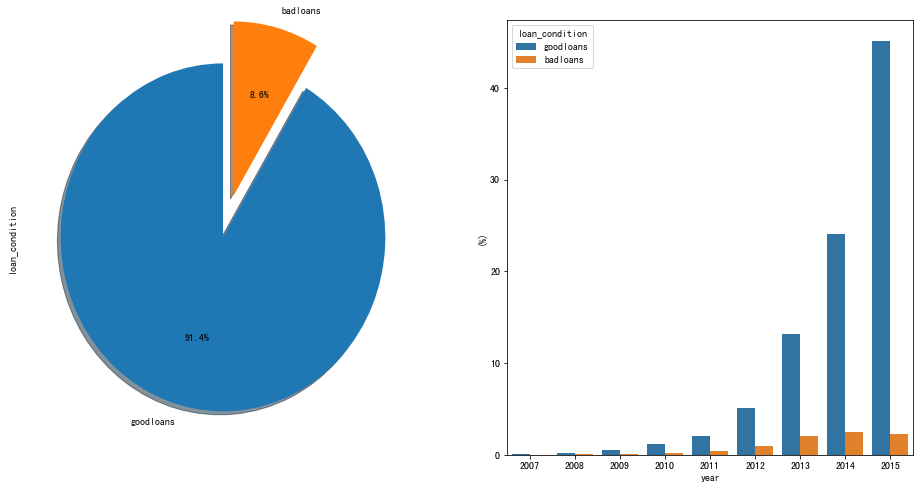

In [12]:
fig1,(ax1,ax2)  = plt.subplots(1,2,figsize = (16,8))
labels = 'goodloans','badloans'
explode = [0,0.25]
loan_data['loan_condition'].value_counts().plot.pie(explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,ax = ax1)

# 好的贷款和坏的贷款随着年份的分布
sns.barplot(x="year", y="loan_amnt", hue="loan_condition", data=loan_data, 
            estimator=lambda x: len(x) / len(loan_data) * 100,ax = ax2)
ax2.set(ylabel="(%)")

plt.show()

In [13]:
loan_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [14]:
loan_data['addr_state'].value_counts()

CA    129517
NY     74086
TX     71138
FL     60935
IL     35476
NJ     33256
PA     31393
OH     29631
GA     29085
VA     26255
NC     24720
MI     22985
MD     21031
MA     20593
AZ     20412
WA     19434
CO     18807
MN     15957
MO     14207
IN     13789
CT     13531
TN     12887
NV     12443
WI     11574
AL     11200
OR     10893
SC     10639
LA     10587
KY      8550
OK      8085
KS      7926
AR      6640
UT      6264
NM      4939
HI      4570
WV      4386
NH      4294
RI      3893
MS      3819
MT      2558
DE      2511
DC      2432
AK      2205
WY      2028
SD      1815
VT      1797
NE      1176
ME       525
ND       479
IA        14
ID        12
Name: addr_state, dtype: int64

## 特征选择

In [15]:
loan_data['inq_last_12m'].isnull().sum()

866007

In [16]:
loan_data['open_il_12m'].isnull().sum()

866007

* 'loan_amnt', 贷款金额
* 'funded_amnt', 贷款时间点贷款金额
* 'funded_amnt_inv',投资者在该时间点对该贷款的承诺总额。
* 'term', 借款周期
* 'int_rate', 贷款利率
* 'installment',如果贷款产生，则借款人每月欠的款项。
* 'grade', 风险等级
* 'sub_grade', 风险子等级
* 'emp_title',工作职称
* 'emp_length',工作年限（数值在0到10之间，等于0意味着小于1年的工作长度，等于10意味着10年或者更长的工作年限） 
* 'home_ownership', 房子状态
* 'annual_inc', 年收入（注册时提供的）
* 'verification_status',（收入来源确认）
* 'issue_d', 贷款融资的月份
* 'loan_status', 贷款状态
* 'pymnt_plan', Indicates if a payment plan has been put in place for the loan,该字段没有意义，删掉
* 'desc', 借款描述（借款者提供）
* 'purpose',贷款目的
* 'title', 贷款名称（借款者提供），并没有特殊的意义
* 'zip_code', 借款者提供的邮政编码的前3位
* 'addr_state', 借款者提供的州名
* 'dti', 借款人负债比
* 'delinq_2yrs',过去2年预逾期30天以上的次数
* 'earliest_cr_line', 借款人最早报告的信贷额度开放的月份
* 'inq_last_6mths',在过去6个月的请求贷款次数，不包括自动和按揭贷款
* 'open_acc',借款人的信用借款额度
* 'revol_bal',尚未结清金额
* 'revol_util', 信用账户使用率
* 'total_acc',借款人信用额度总和
* 'initial_list_status', 贷款信息的初始化状态，F,W，目前来看并没有什么具体的含义
* 'total_pymnt', 迄今已收到的已付款总额
* 'total_pymnt_inv', 迄今收到的款项，占投资者资助总额的一部分
* 'total_rec_prncp',
* 'total_rec_int',
* 'last_pymnt_d',上个月接到的还款 
* 'last_pymnt_amnt',
* 'last_credit_pull_d', 最近一个月LC取消了这笔贷款的信贷
* 'policy_code', 
* 'application_type',申请贷款的类型，个人或者团体等
* 'tot_cur_bal'

![QWuQc4.jpg](https://s2.ax1x.com/2019/12/14/QWuQc4.jpg)

In [17]:
loan_data['home_ownership'].value_counts()

MORTGAGE    443557
RENT        356117
OWN          87470
OTHER          182
NONE            50
ANY              3
Name: home_ownership, dtype: int64

房子的状态：
MORTGAGE：按揭贷款
RENT：租房      
OWN：自有          
OTHER：其他         
NONE：没有           
ANY：任何（可以默认为没有）  

In [18]:
loan_data['installment'].isnull().sum()

0

In [19]:
loan_data['issue_d']

0         Dec-2011
1         Dec-2011
2         Dec-2011
3         Dec-2011
4         Dec-2011
5         Dec-2011
6         Dec-2011
7         Dec-2011
8         Dec-2011
9         Dec-2011
10        Dec-2011
11        Dec-2011
12        Dec-2011
13        Dec-2011
14        Dec-2011
15        Dec-2011
16        Dec-2011
17        Dec-2011
18        Dec-2011
19        Dec-2011
20        Dec-2011
21        Dec-2011
22        Dec-2011
23        Dec-2011
24        Dec-2011
25        Dec-2011
26        Dec-2011
27        Dec-2011
28        Dec-2011
29        Dec-2011
            ...   
887349    Jan-2015
887350    Jan-2015
887351    Jan-2015
887352    Jan-2015
887353    Jan-2015
887354    Jan-2015
887355    Jan-2015
887356    Jan-2015
887357    Jan-2015
887358    Jan-2015
887359    Jan-2015
887360    Jan-2015
887361    Jan-2015
887362    Jan-2015
887363    Jan-2015
887364    Jan-2015
887365    Jan-2015
887366    Jan-2015
887367    Jan-2015
887368    Jan-2015
887369    Jan-2015
887370    Ja

In [20]:
loan_data['pymnt_plan']

0         n
1         n
2         n
3         n
4         n
5         n
6         n
7         n
8         n
9         n
10        n
11        n
12        n
13        n
14        n
15        n
16        n
17        n
18        n
19        n
20        n
21        n
22        n
23        n
24        n
25        n
26        n
27        n
28        n
29        n
         ..
887349    n
887350    n
887351    n
887352    n
887353    n
887354    n
887355    n
887356    n
887357    n
887358    n
887359    n
887360    n
887361    n
887362    n
887363    n
887364    n
887365    n
887366    n
887367    n
887368    n
887369    n
887370    n
887371    n
887372    n
887373    n
887374    n
887375    n
887376    n
887377    n
887378    n
Name: pymnt_plan, Length: 887379, dtype: object

In [21]:
loan_data['title'].value_counts()

Debt consolidation                         414001
Credit card refinancing                    164331
Home improvement                            40112
Other                                       31892
Debt Consolidation                          15760
Major purchase                              12051
Business                                     6728
Medical expenses                             6674
Car financing                                5565
Consolidation                                5381
debt consolidation                           4834
Moving and relocation                        3921
Vacation                                     3805
Debt Consolidation Loan                      3804
Home buying                                  2365
Credit Card Consolidation                    2359
consolidation                                2174
Personal Loan                                2133
Consolidation Loan                           1778
Home Improvement                             1772


In [22]:
loan_data['dti']

0         27.65
1          1.00
2          8.72
3         20.00
4         17.94
5         11.20
6         23.51
7          5.35
8          5.55
9         18.08
10        16.12
11        10.78
12        10.08
13        12.56
14         7.06
15        20.31
16        18.60
17        10.52
18        18.44
19         9.86
20        26.53
21        13.22
22        11.18
23        16.01
24         2.40
25        29.44
26        15.22
27        13.97
28         5.63
29        12.19
          ...  
887349    27.24
887350    15.72
887351    36.93
887352     8.47
887353    15.77
887354     2.84
887355    18.11
887356    31.95
887357    11.28
887358     5.27
887359     5.52
887360    29.60
887361    17.09
887362    17.62
887363    25.65
887364    13.22
887365    16.80
887366    18.58
887367    33.66
887368     1.00
887369    12.63
887370    25.63
887371    29.44
887372    23.69
887373    27.08
887374    28.69
887375     3.90
887376    30.90
887377    27.19
887378    10.83
Name: dti, Length: 88737

In [23]:
loan_data['earliest_cr_line']

0         Jan-1985
1         Apr-1999
2         Nov-2001
3         Feb-1996
4         Jan-1996
5         Nov-2004
6         Jul-2005
7         Jan-2007
8         Apr-2004
9         Sep-2004
10        Jan-1998
11        Oct-1989
12        Apr-2004
13        Jul-2003
14        May-1991
15        Sep-2007
16        Oct-1998
17        Aug-1993
18        Oct-2003
19        Jan-2001
20        Nov-1997
21        Feb-1983
22        Jul-1985
23        Apr-2003
24        Jun-2001
25        Feb-2002
26        Oct-2003
27        Oct-2003
28        Aug-1984
29        Nov-2006
            ...   
887349    Mar-1998
887350    Aug-2002
887351    Aug-1990
887352    Dec-2006
887353    Jan-1989
887354    Jun-2001
887355    Jun-1993
887356    Dec-1994
887357    Jul-2002
887358    May-2003
887359    May-2003
887360    Aug-1983
887361    Oct-1994
887362    Sep-2003
887363    Oct-2006
887364    Nov-1975
887365    Nov-2006
887366    Feb-2011
887367    Mar-2000
887368    May-1994
887369    Sep-2002
887370    Au

In [24]:
loan_data['inq_last_6mths'].value_counts()

0.0     497905
1.0     241494
2.0      94117
3.0      37398
4.0      10758
5.0       3985
6.0       1231
7.0        195
8.0        122
9.0         50
10.0        24
11.0        15
12.0        15
15.0         9
14.0         6
13.0         6
18.0         4
16.0         3
17.0         2
19.0         2
24.0         2
31.0         1
32.0         1
25.0         1
28.0         1
20.0         1
33.0         1
27.0         1
Name: inq_last_6mths, dtype: int64

In [25]:
loan_data['revol_util'].value_counts()

0.00      3540
58.00     1780
53.00     1766
59.00     1765
61.00     1757
57.00     1722
62.00     1720
52.00     1709
55.00     1699
63.00     1697
60.00     1693
54.00     1690
48.00     1675
47.00     1654
65.00     1652
50.00     1649
56.00     1636
51.00     1627
64.00     1626
66.00     1621
46.00     1614
49.00     1606
68.00     1589
67.00     1587
44.00     1582
70.00     1572
72.00     1559
69.00     1556
71.00     1526
43.00     1509
          ... 
21.72        1
116.80       1
32.71        1
115.80       1
21.59        1
153.70       1
127.10       1
118.20       1
129.40       1
161.50       1
0.04         1
128.10       1
127.40       1
33.29        1
128.60       1
0.05         1
2.64         1
8.49         1
130.10       1
36.94        1
49.69        1
39.95        1
141.10       1
32.04        1
130.40       1
121.10       1
21.92        1
12.42        1
121.40       1
133.10       1
Name: revol_util, Length: 1356, dtype: int64

In [26]:
loan_data['initial_list_status'].value_counts()

f    456848
w    430531
Name: initial_list_status, dtype: int64

In [27]:
loan_data['pymnt_plan'].value_counts()

n    887369
y        10
Name: pymnt_plan, dtype: int64

In [28]:
loan_data['application_type'].value_counts()

INDIVIDUAL    886868
JOINT            511
Name: application_type, dtype: int64

In [29]:
loan_data['policy_code'].value_counts()

1.0    887379
Name: policy_code, dtype: int64

### 数据探索

### 不同工作年限的分布

Text(0,0.5,'counts')

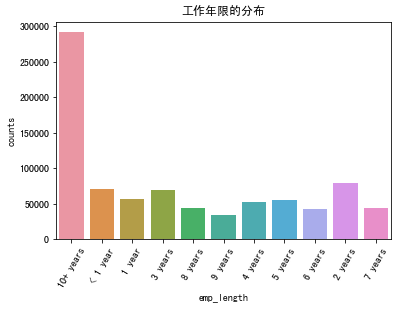

In [30]:
# 画图展示工作年限的分布
# plot
fig,ax = plt.subplots(1,1)
sns.countplot(x = 'emp_length',data = loan_data,ax = ax,)
#sns.barplot(columns,age_test,ax = ax2)

plt.xticks(rotation=60)
ax.set_title('工作年限的分布')
#ax2.set_title('test_dataset')
ax.set_ylabel('counts')

可以看到大部分的借款者的工作年限都在10年或者10年以上，而其他分布则是或高或低，没有一个很明显的规律。

查看坏账当中，工作年限的分布是如何的？

Text(0,0.5,'counts')

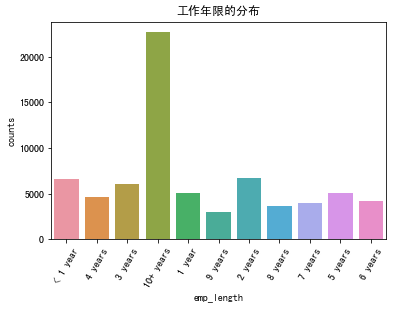

In [31]:
fig,ax = plt.subplots(1,1)
sns.countplot(x = 'emp_length',data = loan_data[loan_data['loan_condition'] == 'badloans'],ax = ax)
#sns.barplot(columns,age_test,ax = ax2) 

plt.xticks(rotation=60)
ax.set_title('工作年限的分布')
#ax2.set_title('test_dataset')
ax.set_ylabel('counts')

从上面的图片可知，在坏账当中，工作年限10年以上的仍然是出现坏账概率比较大。这也是因为工作年限10年以上的用户借款最多，所以导致出现坏账的占比也较大，在审核工作年限10年以上的用户的贷款时，需要更加严格才行。

In [32]:
?sns.barplot

### 随着时间变化，贷款总量的变化

可以看到随着时间的增长，贷款总量一直在增加，其中2015年最高，意味着经济正在回暖，变得越来越好。

/Users/wh-js/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'平均贷款总量')

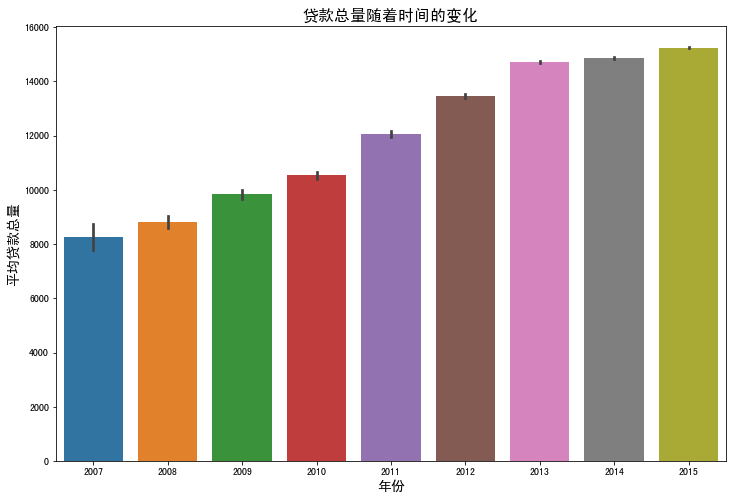

In [33]:
# The year of 2015 was the year were the highest amount of loans were issued 
# This is an indication that the economy is quiet recovering itself.
plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amnt', data=loan_data, palette='tab10')
plt.title('贷款总量随着时间的变化', fontsize=16)
plt.xlabel('年份', fontsize=14)
plt.ylabel('平均贷款总量', fontsize=14)

### 不同贷款类型的金额占比

/Users/wh-js/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'平均贷款金额')

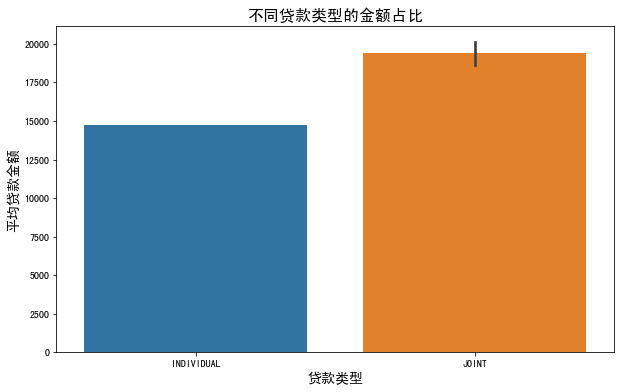

In [34]:
# The year of 2015 was the year were the highest amount of loans were issued 
# This is an indication that the economy is quiet recovering itself.
plt.figure(figsize=(10,6))
sns.barplot('application_type', 'loan_amnt', data=loan_data, palette='tab10')
plt.title('不同贷款类型的金额占比', fontsize=16)
plt.xlabel('贷款类型', fontsize=14)
plt.ylabel('平均贷款金额', fontsize=14)

探索不同利率的分布是怎么样的。

/Users/wh-js/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'金额')

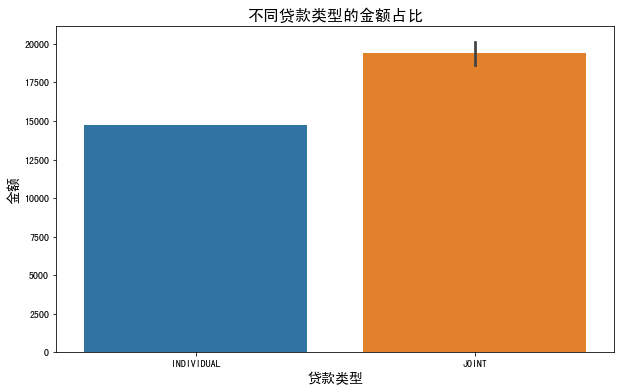

In [38]:
plt.figure(figsize=(10,6))
sns.barplot('application_type', 'loan_amnt', data=loan_data, palette='tab10')
plt.title('不同贷款类型的金额占比', fontsize=16)
plt.xlabel('贷款类型', fontsize=14)
plt.ylabel('金额', fontsize=14)

### 借款者年收入如何，与坏账之间有和关系？

In [39]:
loan_data['annual_inc'].value_counts()

60000.00     34281
50000.00     30575
65000.00     25498
70000.00     24121
40000.00     23943
80000.00     22729
45000.00     22699
75000.00     22435
55000.00     20755
90000.00     17159
100000.00    17131
85000.00     15648
35000.00     14868
30000.00     13764
120000.00    13202
52000.00     12174
42000.00     11705
48000.00     11330
110000.00    11090
72000.00      9656
95000.00      9274
150000.00     8136
62000.00      7770
36000.00      7700
38000.00      7208
125000.00     7006
32000.00      6774
54000.00      6627
58000.00      6621
56000.00      6557
             ...  
65032.00         1
65033.00         1
65035.00         1
65037.00         1
26260.00         1
65039.00         1
49275.22         1
65041.00         1
65045.00         1
101081.00        1
25270.00         1
25269.00         1
65052.00         1
15964.00         1
36895.02         1
65056.00         1
82999.92         1
73330.67         1
65062.00         1
101073.00        1
65065.00         1
101069.00   

In [40]:
loan_data['annual_inc'].describe()

count    8.873750e+05
mean     7.502759e+04
std      6.469830e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64

从上面可以看出来借款者的年收入最大为950万，最小为0万，平均值为75027美元，50%中位数为65000美元，25%中位数为45000美元，75%中位数为90000美元。

所以可以划分年收入家庭的类型，以2万为一个阶梯进行年收入划分。

In [41]:
def anaul_income(income):
    if income <= 20000:
        return '0-2万'
    elif income <= 40000:
        return '2-4万'
    elif income <= 60000:
        return '4-6万'
    elif income <= 80000:
        return '6-8万'
    elif income <= 100000:
        return '8-10万'
    elif income <= 200000:
        return '10-20万'
    else:
        return '中产以上家庭'

Text(0,0.5,'counts')

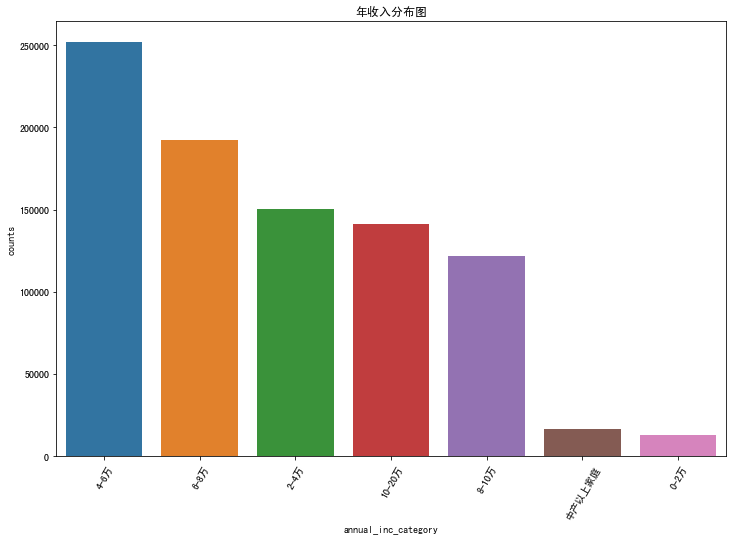

In [42]:
loan_data['annual_inc_category'] = loan_data['annual_inc'].apply(anaul_income)
# plot
fig,ax = plt.subplots(1,1,figsize = (12,8))
sns.countplot(x='annual_inc_category',data = loan_data,ax = ax,
              order = loan_data['annual_inc_category'].value_counts().index)
plt.xticks(rotation = 60)
ax.set_title('年收入分布图')
ax.set_ylabel('counts')

可以看到在借款者当中，4-6万的人数居多，6-8万人数排第二，这些年收入的分布非常符合美国家庭的年收入。而0-2万的比较少，有可能是收入过少，风控管得严，所以很难借到款，而中产以上家庭较少，则可能是因为收入已经很好了，不需要去借款。

[![QftRs0.md.png](https://s2.ax1x.com/2019/12/15/QftRs0.md.png)](https://imgse.com/i/QftRs0)

#### 年收入与坏账之间的联系？

Text(0,0.5,'counts')

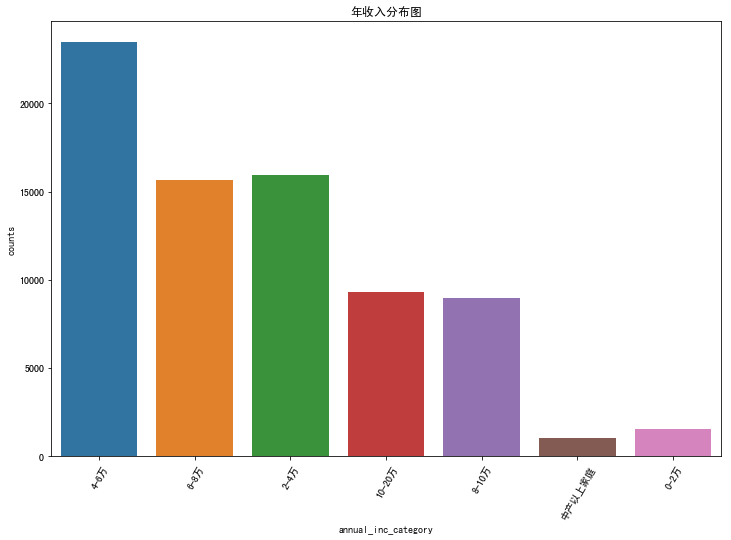

In [43]:
fig,ax = plt.subplots(1,1,figsize = (12,8))
sns.countplot(x='annual_inc_category',data = loan_data[loan_data['loan_condition'] == 'badloans'],
              ax = ax,order = loan_data['annual_inc_category'].value_counts().index)
plt.xticks(rotation = 60)
ax.set_title('年收入分布图')
ax.set_ylabel('counts')

当年收入在4-6万的时候，也最容易出现坏账。推测有可能是家庭需要用钱，生活压力大难以还款等等。

### 风险等级的分布以及哪个风险等级最容易出现坏账

In [44]:
loan_data['grade'].value_counts()

B    254535
C    245860
A    148202
D    139542
E     70705
F     23046
G      5489
Name: grade, dtype: int64

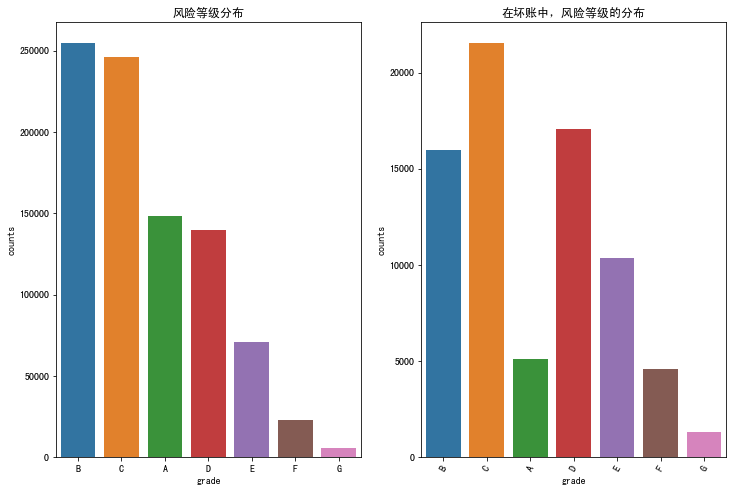

In [45]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,8))

sns.countplot(x='grade',data=loan_data,ax = ax1,
              order = loan_data['grade'].value_counts().index)

sns.countplot(x='grade',data=loan_data[loan_data['loan_condition'] == 'badloans'],ax = ax2,
             order = loan_data['grade'].value_counts().index)

plt.xticks(rotation = 60)
ax1.set(ylabel='counts')
ax1.set_title('风险等级分布')
ax2.set(ylabel='counts')
ax2.set_title('在坏账中，风险等级的分布')

plt.show()

看出来在贷款者当中，B级人数最多，风险等级人数比较集中于ABCDE，而F，G人数较少，风险等级不好，在申请贷款的时候，就很难审核通过。
而在出现坏账的人群中，C级出现的人数最多，其次是D级，再次是B级，A级相对较少，出现逾期的人数比较集中于BCDE等级的人数中，在做风控的时候，就要严格管控，以防止出现逾期。

### 借款者的房子状态如何，房子状态和出现逾期之间的关系如何？

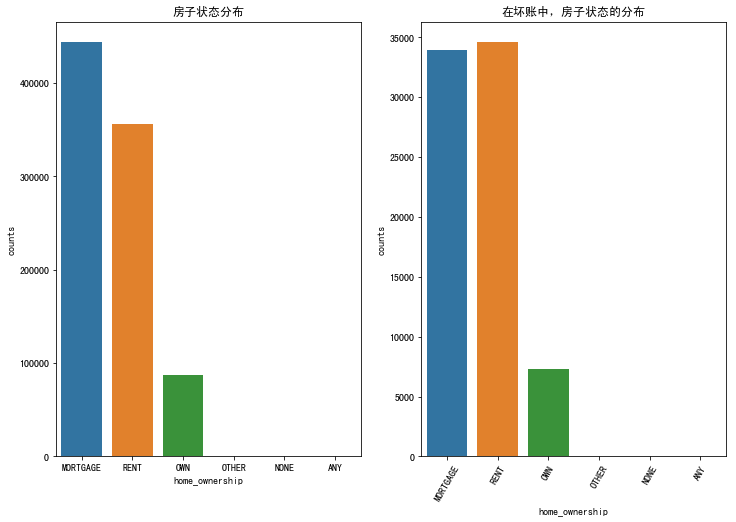

In [46]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,8))

sns.countplot(x='home_ownership',data=loan_data,ax = ax1,
              order = loan_data['home_ownership'].value_counts().index)

sns.countplot(x='home_ownership',data=loan_data[loan_data['loan_condition'] == 'badloans'],ax = ax2,
             order = loan_data['home_ownership'].value_counts().index)

plt.xticks(rotation = 60)
ax1.set(ylabel='counts')
ax1.set_title('房子状态分布')
ax2.set(ylabel='counts')
ax2.set_title('在坏账中，房子状态的分布')

plt.show()

In [47]:
loan_data['home_ownership'].value_counts()

MORTGAGE    443557
RENT        356117
OWN          87470
OTHER          182
NONE            50
ANY              3
Name: home_ownership, dtype: int64

从上面大部分用户的房子是在按揭还放贷当中，或者是租房，而在坏账当中，租房子和按揭还放贷的人数差不多占了大部分，还有一小部分人是自有住房。所以在对用户进行放贷时，要根据用户的房子状态进行审核。

### 借款者的借款目分布，哪种目的可能出现坏账

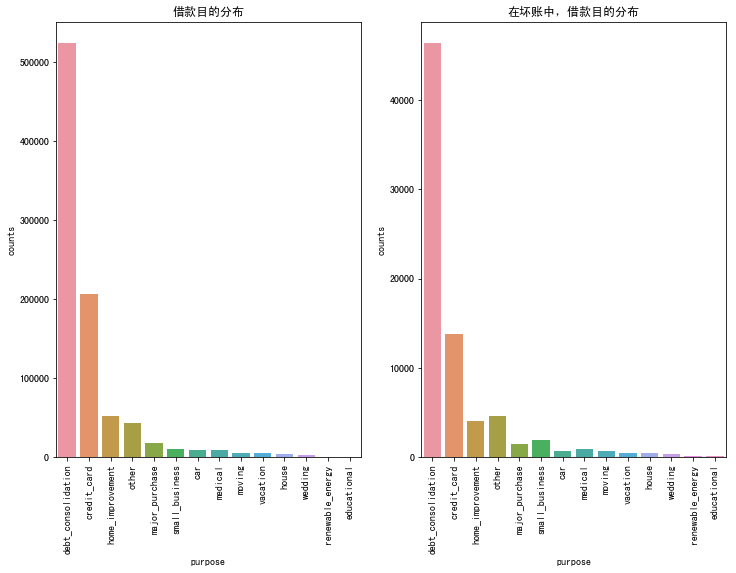

In [48]:
fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,figsize = (12,8))

sns.countplot(x='purpose',data=loan_data,ax = ax1,
              order = loan_data['purpose'].value_counts().index)

sns.countplot(x='purpose',data=loan_data[loan_data['loan_condition'] == 'badloans'],ax = ax2,
             order = loan_data['purpose'].value_counts().index)

# plt.xticks(rotation = 90)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set(ylabel='counts')
ax1.set_title('借款目的分布')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set(ylabel='counts')
ax2.set_title('在坏账中，借款目的分布')

plt.show()

In [49]:
loan_data['purpose'].value_counts()

debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

用户贷款的目的主要是债务合并贷款（债务合并主要是为了达到更低的利率），在出现坏账中，债务合并也是排在第一位，所以后续重点关注需要债务合并的人群，做好风控，以防出现逾期。

## 特征工程

由上面的分析可知，在74个特征当中，有些特征与逾期并没有关系，而有些特征由于缺失值过多，直接舍弃，所以本次总共有效的特征如下：

部分类别型的变量过于复杂，在这里也不做分析。

tot_cur_bal 缺失值过多，占据了8%左右的样本数据，所以舍弃该特征。

* subgrade:与grade 信息有重复，选择删除
* issue_d: 在是否逾期当中，时间不应该成为考虑因素。这里提前向模型泄露了信息，同时生成的year 也需要删掉
* addr_state：51个州名，这里不做特征选择，与是否逾期无关
* earliest_cr_line：借款人第一次有信贷额度的时间，与逾期无关
* 预测贷款违约模型是不能知道贷后的信息，否则无法做相应的风险控制，本模型需要简化，因此需要将一些贷后特征删除，last_pymnt_d，last_pymnt_amnt，last_credit_pull_d
* loan_status : 这个特征也需要删除，因为已经生成了一个二分类变量 loan_condition
* annual_inc ：已将该数值变量转为分类变量，所以需要删掉

In [50]:
columns = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade',  
       'emp_length', 'home_ownership', 'verification_status',
        'purpose','loan_condition',
     'dti', 'delinq_2yrs',
    'inq_last_6mths',
       'open_acc', 'revol_bal',
       'revol_util', 'total_acc', 
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 
        'application_type',
        'annual_inc_category']

In [51]:
new_loan_data = loan_data[columns]

In [52]:
new_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 25 columns):
loan_amnt              887379 non-null float64
funded_amnt            887379 non-null float64
funded_amnt_inv        887379 non-null float64
term                   887379 non-null object
int_rate               887379 non-null float64
installment            887379 non-null float64
grade                  887379 non-null object
emp_length             842554 non-null object
home_ownership         887379 non-null object
verification_status    887379 non-null object
purpose                887379 non-null object
loan_condition         887379 non-null object
dti                    887379 non-null float64
delinq_2yrs            887350 non-null float64
inq_last_6mths         887350 non-null float64
open_acc               887350 non-null float64
revol_bal              887379 non-null float64
revol_util             886877 non-null float64
total_acc              887350 non-null float64
tot

看到，在新的数据框中，由原来的74的特征变为了25个特征，接下来对特征进行类型的转换，首先需要先了解每一个特征的数据类型，然后将其转换为数字类型，以方便进行处理。

对上面的缺失值进行填充处理，emp_length缺失值是最多的，将近有4万条缺失值，delinq_2yrs，open_acc，revol_util，total_acc缺失值较少，可以选取平均值作为其填充值。

In [53]:
new_loan_data['emp_length'] = new_loan_data['emp_length'].fillna(method='bfill')  
# 这里采用缺失值的后一个数值对缺失值进行填充

/Users/wh-js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


关于缺失值的处理可以查看机器学习中如何处理缺失数据？[- pro-am的回答 - 知乎](https://www.zhihu.com/question/26639110/answer/147731341)

对于数值型数值，直接使用sklearn 提供的imputer 模块来进行填充。

In [54]:
new_loan_data.isnull().sum() # 查看还有多少缺失值

loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
term                     0
int_rate                 0
installment              0
grade                    0
emp_length               0
home_ownership           0
verification_status      0
purpose                  0
loan_condition           0
dti                      0
delinq_2yrs             29
inq_last_6mths          29
open_acc                29
revol_bal                0
revol_util             502
total_acc               29
total_pymnt              0
total_pymnt_inv          0
total_rec_prncp          0
total_rec_int            0
application_type         0
annual_inc_category      0
dtype: int64

In [59]:
number_columns_missing = ['delinq_2yrs','inq_last_6mths','open_acc','revol_util','total_acc']
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
new_loan_data_imputed = imputer.fit(new_loan_data[number_columns_missing])

In [60]:
new_loan_data[number_columns_missing] = imputer.transform(new_loan_data[number_columns_missing])

/Users/wh-js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/wh-js/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [61]:
new_loan_data.isnull().sum()

loan_amnt              0
funded_amnt            0
funded_amnt_inv        0
term                   0
int_rate               0
installment            0
grade                  0
emp_length             0
home_ownership         0
verification_status    0
purpose                0
loan_condition         0
dti                    0
delinq_2yrs            0
inq_last_6mths         0
open_acc               0
revol_bal              0
revol_util             0
total_acc              0
total_pymnt            0
total_pymnt_inv        0
total_rec_prncp        0
total_rec_int          0
application_type       0
annual_inc_category    0
dtype: int64

从上面可以看到缺失值已经全部处理完毕，接下来可以对类别型变量进行处理了。

### 有序分类型变量处理

首先将我们的目标变量，也就是我们需要预测用户是否会逾期的变量 loan_condition 给转换成数值，方便我们的算法进行建模。

In [62]:
new_loan_data['loan_condition'] = new_loan_data['loan_condition'].apply(lambda x: 0 if x == 'goodloans' else 1)

/Users/wh-js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


上面我们就已经将目标变量转换成了0，1这样的数值以方便模型可以很好地利用了。接下来就是对有序分类变量进行处理。

In [63]:
object_columns_df =new_loan_data.select_dtypes(include=["object"]) #筛选数据类型为object的变量
print(object_columns_df.iloc[0])

term                     36 months
grade                            B
emp_length               10+ years
home_ownership                RENT
verification_status       Verified
purpose                credit_card
application_type        INDIVIDUAL
annual_inc_category           2-4万
Name: 0, dtype: object


In [ ]:
# term 分类变量处理

In [65]:
new_loan_data['term'].value_counts()

 36 months    621125
 60 months    266254
Name: term, dtype: int64

In [ ]:
# data = new_loan_data['term'].apply(lambda x: 1 if x == '36 months' else 0)

In [ ]:
# data.value_counts()

In [66]:
new_loan_data['term'].apply(lambda x: x.strip())

0         36 months
1         60 months
2         36 months
3         36 months
4         60 months
5         36 months
6         60 months
7         36 months
8         60 months
9         60 months
10        60 months
11        36 months
12        36 months
13        36 months
14        36 months
15        36 months
16        36 months
17        36 months
18        36 months
19        36 months
20        60 months
21        36 months
22        36 months
23        36 months
24        36 months
25        36 months
26        36 months
27        60 months
28        36 months
29        36 months
            ...    
887349    36 months
887350    60 months
887351    36 months
887352    36 months
887353    60 months
887354    36 months
887355    36 months
887356    60 months
887357    60 months
887358    60 months
887359    60 months
887360    60 months
887361    36 months
887362    36 months
887363    36 months
887364    36 months
887365    36 months
887366    36 months
887367    36 months


In [67]:
# 构建mapping，对有序变量“emp_length”,'grade' ,无序变量 term 也进行转换
mapping_dict = {
    'emp_length':{
        '10+ years':10,
        '9 years':9,
        '8 years':8,
        '7 years':7,
        '6 years':6,
        '5 years':5,
        '4 years':4,
        '3 years':3,
        '2 years':2,
        '1 year':1,
        '< 1 year':0,
    },
    'grade':{
       'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
    },
    'term':{
        ' 36 months': 1,
        ' 60 months': 0,  
    }  
}

In [68]:
new_loan_data = new_loan_data.replace(mapping_dict)

In [69]:
new_loan_data[['emp_length','grade','term']].head()

,emp_length,grade,term
0,10,2,1
1,0,3,0
2,10,3,1
3,10,3,1
4,1,2,0


还有一个年收入的有序类别变量没有处理，下面进行如上一样的处理方法：

In [70]:
new_loan_data['annual_inc_category'].value_counts()

4-6万      251931
6-8万      192177
2-4万      150449
10-20万    140977
8-10万     121948
中产以上家庭     16790
0-2万       13107
Name: annual_inc_category, dtype: int64

In [71]:
def annual_inc_category(status):
    if status == '0-2万':
        return 0
    elif status == '2-4万':
        return 1
    elif status == '4-6万':
        return 2
    elif status == '6-8万':
        return 3
    elif status == '8-10万':
        return 4
    elif status == '10-20万':
        return 5
    else:
        return 6

new_loan_data['annual_inc_category'] = new_loan_data['annual_inc_category'].apply(annual_inc_category)

这里对于多值有序的分类变量已经处理完毕了，接下来就是处理无序的分类变量，无序分类变量指的是多值变量之间没有顺序，没有大小之分，所以只能作为无序变量。

### 无序分类变量处理

In [73]:
object_columns_df =new_loan_data.select_dtypes(include=["object"]) #筛选数据类型为object的变量
print(object_columns_df.iloc[0])

home_ownership                RENT
verification_status       Verified
purpose                credit_card
application_type        INDIVIDUAL
Name: 0, dtype: object


对待多值无序变量可以使用one-hot encoding来进行数据的转换。可以使用pandas 的get_dummies 函数来创建一个虚拟的特征，再利用pandas的 concat 函数将虚拟的特征和原来的数据框合并，就可以完成无序分类变量的转换了。

In [74]:
n_columns = ['home_ownership','verification_status','purpose','application_type']
new_onehot_dataframe = pd.get_dummies(new_loan_data[n_columns])

In [75]:
new_loan_data_all = pd.concat((new_loan_data,new_onehot_dataframe),axis=1)

从数据框中删除上面的四个分类变量

In [76]:
new_loan_data_all.drop(n_columns,axis=1,inplace=True)

### 对数据进行标准化 

需要对数据进行降维，标准化，让数据能够在同一个维度上进行比较。常见的标准化可以使用sklearn 提供的 StandardScaler 模块。

**注意：这里还没有划分训练集和测试集，在标准化数据的时候要将目标变量划分出来**

In [77]:
y = new_loan_data_all['loan_condition']

In [78]:
new_loan_data_all.drop(['loan_condition'],axis = 1,inplace=True)

In [79]:
scaler = StandardScaler()
new_loan_standard = scaler.fit_transform(new_loan_data_all)

In [80]:
new_loan_standard

array([[-1.15646037, -1.1556348 , -1.1522562 , ..., -0.05149642,
         0.02400385, -0.02400385],
       [-1.45282864, -1.45219848, -1.44542964, ..., -0.05149642,
         0.02400385, -0.02400385],
       [-1.46468337, -1.46406102, -1.45727503, ..., -0.05149642,
         0.02400385, -0.02400385],
       ...,
       [-0.2080819 , -0.20663105, -0.20166357, ..., -0.05149642,
         0.02400385, -0.02400385],
       [-0.32662921, -0.32525652, -0.32011748, ..., -0.05149642,
         0.02400385, -0.02400385],
       [ 0.62174927,  0.62374723,  0.62751381, ..., -0.05149642,
         0.02400385, -0.02400385]])

将Numpy 数组还原成DataFrame。

In [81]:
new_loan_data_all_column_names = new_loan_data_all.columns

In [82]:
new_loan_standard = pd.DataFrame(new_loan_standard,columns = new_loan_data_all_column_names)

### 特征选择

关于特征选择，本次通过皮尔逊相关系数来查看各个变量之间的关系，查看他们是否有强相关性，如果有很强的相关性，那么就从中挑选一个特征作为代表来进行建模。

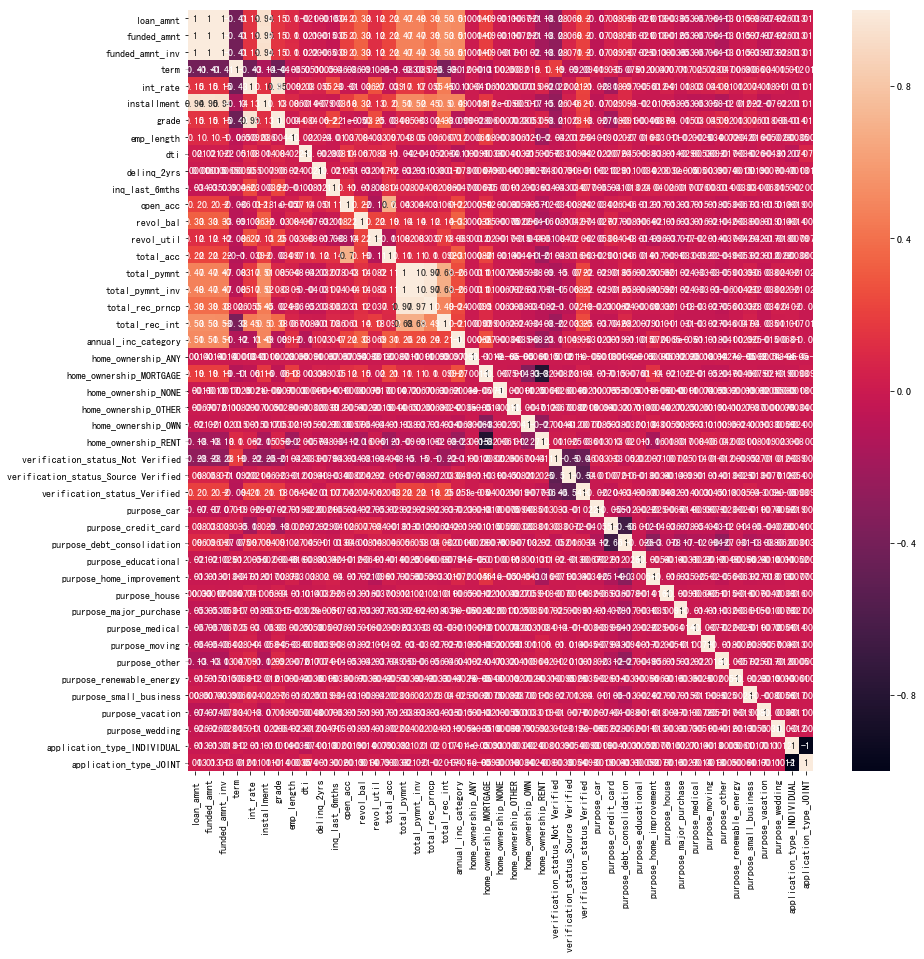

In [83]:
corr = new_loan_standard.corr()
plt.figure(figsize=(14,14))
# annot 显示每个方格的数字
sns.heatmap(corr,annot = True) 

通过上面的图例可以看出来：存在强相关性的变量有如下这些
1. 'loan_amnt', 'funded_amnt', 'funded_amnt_inv'，installment
2. int_rate 和 grade
3.  'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp'
4. 'application_type_INDIVIDUAL','application_type_JOINT'

从上面的相关性变量中选取其中一个作为代表即可。

In [84]:
drop_columns = ['funded_amnt','funded_amnt_inv',
                'installment','grade','total_pymnt_inv','total_rec_prncp','application_type_JOINT']

In [85]:
model_loan = new_loan_standard.drop(drop_columns,axis = 1,inplace=True)

## 模型训练

In [86]:
# 构建自变量和因变量
X = new_loan_data_all
# y 之前已经构建了
# 查看正样本和负样本之间的比例
y.shape

(887379,)

In [87]:
n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y==1].shape[0]
print("查看正负样本和总样本之间的比例，样本数{}，正样本比例{}，负样本比例{}".format(n_sample,
                                                     n_pos_sample/n_sample,
                                                    n_neg_sample/n_sample))

查看正负样本和总样本之间的比例，样本数887379，正样本比例0.91447960792401，负样本比例0.08552039207599008


### 处理样本不平衡
本次正负样本非常不均衡，正负样本之间相差了很多，在本次分析中92%的人都是正常的不会出现逾期的人，而我们需要预测的哪些人有可能会出现逾期，并且将其预测出来，采取一定的措施，比如进行更严格的风控措施等等。所以对于模型的训练，训练集和测试集都需要按照比例划分出来，以达到模型更加精确。

In [88]:
# 使用imlbearn库中上采样方法中的SMOTE接口
from imblearn.over_sampling import SMOTE
# 定义SMOTE模型，random_state相当于随机数种子的作用
smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_sample(X, y)

再次查看正负样本的比例，可以看到正负样本的比例都为0.5.

In [89]:
n_sample = y_smo.shape[0]
n_pos_sample = y_smo[y_smo == 0].shape[0]
n_neg_sample = y_smo[y_smo==1].shape[0]
print("查看正负样本和总样本之间的比例，样本数{}，正样本比例{}，负样本比例{}".format(n_sample,
                                                     n_pos_sample/n_sample,
                                                    n_neg_sample/n_sample))

查看正负样本和总样本之间的比例，样本数1622980，正样本比例0.5，负样本比例0.5


### 建模与模型评估

In [91]:
# 划分训练集和测试集
train_x,test_x,train_y,test_y = train_test_split(X_smo,y_smo,test_size = 0.3,random_state = 33)

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve
from sklearn.metrics import accuracy_score

In [95]:
# 创建逻辑回归分类器
clf = LogisticRegression()
# 使用GridSearchCV来优化分类器的参数
param_grid = {'C':[0.01,0.1,1,10,100,1000,],
             'penalty':['l1','l2']}

lg = GridSearchCV(clf,param_grid=param_grid,cv = 10)
lg.fit(train_x,train_y)

/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converg

/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converg

/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/wh-js/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.5f}".format(grid_search.best_score_))

查看最好的模型参数和分数是什么？

In [96]:
print('Best parameters:{}'.format(lg.best_params_))
print('Best score:{}'.format(lg.best_score_))

Best parameters:{'C': 0.1, 'penalty': 'l2'}
Best score:0.7474249295667267


用训练好的模型在测试集上进行测试：

In [98]:
predicted_y = lg.predict(test_x)

In [102]:
# 查看模型的准确度是否足够准确：
print('模型的准确度：{}'.format(accuracy_score(test_y,predicted_y)))

模型的准确度：0.7485058349455939
